<a href="https://colab.research.google.com/github/Many98/real_estate/blob/criminality/notebooks/criminality_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geopandas -U 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.4 MB/s 
     |████████████████████████████████| 7.8 MB 42.2 MB/s 
     |████████████████████████████████| 16.6 MB 96 kB/s 


In [2]:
!pip install geocube -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 20.9 MB 1.3 MB/s 
     |████████████████████████████████| 114 kB 40.8 MB/s 
     |████████████████████████████████| 53 kB 484 kB/s 


In [78]:
import numpy as np
import pandas as pd
import xarray as xr
import datetime 
import matplotlib.pyplot as plt
import geopandas as gdp
import json
from functools import partial
from shapely.geometry import box, mapping

from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata, rasterize_points_radial
from geocube.rasterize import rasterize_image


%matplotlib inline

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
pd.set_option('display.max_columns', None)
df_nopred = pd.read_csv('/content/drive/MyDrive/reality/dataset_2.csv', sep=',', delimiter=None, encoding="utf8")

## Loading prepared dataset

In [5]:
df2 = pd.read_csv('/content/drive/MyDrive/reality/discounted_crime_2.csv', sep=',', delimiter=None, encoding="utf8")

In [6]:
df2 = df2.rename(columns={"disc_index": "disc_crime"})

Mame data od roku 2016

In [7]:
df2.head()

,Unnamed: 0,index,id,x,y,date,types,crime_idx,cut_x,cut_y,disc_crime
0,0,85,6027950,14.423841,50.089270,2016-01-02,krádeže na osobách,0.038462,"(14.423, 14.425]","(50.0885, 50.0894]",0.020440
1,1,86,6027956,14.448420,50.082480,2016-01-02,krádeže součástek aut,0.031111,"(14.448, 14.449]","(50.0822, 50.0831]",0.016534
2,2,87,6027958,14.418877,50.077282,2016-01-02,vloupání do prodejny,0.038462,"(14.417, 14.419]","(50.0768, 50.0777]",0.020440
3,3,88,6027982,14.427781,50.078349,2016-01-02,krádeže na osobách,0.038462,"(14.426, 14.428]","(50.0777, 50.0786]",0.020440
4,4,89,6028004,14.421398,50.084477,2016-01-02,krádeže na osobách,0.038462,"(14.421, 14.423]","(50.084, 50.0849]",0.020440


In [8]:
df2.columns

Index(['Unnamed: 0', 'index', 'id', 'x', 'y', 'date', 'types', 'crime_idx',
       'cut_x', 'cut_y', 'disc_crime'],
      dtype='object')

In [9]:
df2.types.drop_duplicates().values.tolist()

['krádeže na osobách',
 'krádeže součástek aut',
 'vloupání do prodejny',
 'krádeže motorových vozidel (dvoustopových)',
 'krádeže jízdních kol',
 'loupež',
 'vloupání do bytu',
 'vydírání',
 'úmyslné ublížení na zdraví',
 'vloupání do rodinných domů',
 'vloupání do ubytovacích objektů',
 'dopravní nehody',
 'výtržnictví',
 'vloupání do restaurace',
 'nebezpečné vyhrožování',
 'omezování osobní svobody',
 'obecné ohrožení',
 'krádeže motorových vozidel (jednostopových)',
 'nedovolené ozbrojování',
 'útok proti výkonu pravomoci stát. orgánu',
 'vražda',
 'chladná zbraň',
 'násilí proti skupině/jednotlivci',
 'střelná zbraň',
 'rvačka',
 'obchod s lidmi',
 'únos']

In [10]:
crimeslist = df2.types.drop_duplicates().values.tolist()
categorical_enums = {'types': crimeslist}

## MAP

In [13]:
df3 = df2[['id', 'x',	'y', 'disc_crime']].copy()

In [14]:
df3['xy'] = list(zip(df3.x, df3.y))

In [15]:
df3.head()

,id,x,y,disc_crime,xy
0,6027950,14.423841,50.089270,0.020440,"(14.423841, 50.08927)"
1,6027956,14.448420,50.082480,0.016534,"(14.44842, 50.08248)"
2,6027958,14.418877,50.077282,0.020440,"(14.418877, 50.077282)"
3,6027982,14.427781,50.078349,0.020440,"(14.427781, 50.078349)"
4,6028004,14.421398,50.084477,0.020440,"(14.421398, 50.084477)"


In [16]:
df3 = df3[df3.columns.difference(['x', 'y'])]

In [18]:
help1 = df3.groupby(['xy']).apply(lambda df3: df3['disc_crime'].sum())

In [19]:
df4 = df3.groupby( ['xy'] ).count()

In [20]:
df4['disc_crime'] = help1

In [21]:
df_final = df4[df4.columns.difference(['id'])]

In [22]:
df_final.head()

,disc_crime
xy,
"(14.252392, 50.059311)",0.100560
"(14.263671, 50.109646)",3.158116
"(14.268226, 50.10447)",2.936840
"(14.26839, 50.059282)",0.258757
"(14.26859, 50.096719)",0.057759


In [23]:
df_final= df_final.reset_index()

In [24]:
df_final['xy'].nunique()

1724

In [25]:
df_final[['x', 'y']] = pd.DataFrame(df_final['xy'].tolist(), index=df_final.index)

In [26]:
df_final = df_final[df_final.columns.difference(['xy'])]

In [27]:
df_final.head()

,disc_crime,x,y
0,0.100560,14.252392,50.059311
1,3.158116,14.263671,50.109646
2,2.936840,14.268226,50.104470
3,0.258757,14.268390,50.059282
4,0.057759,14.268590,50.096719


In [28]:
gdf2 = gdp.GeoDataFrame(
    df_final, geometry=gdp.points_from_xy(df_final.x, df_final.y))

In [29]:
gdf2

,disc_crime,x,y,geometry
0,0.100560,14.252392,50.059311,POINT (14.25239 50.05931)
1,3.158116,14.263671,50.109646,POINT (14.26367 50.10965)
2,2.936840,14.268226,50.104470,POINT (14.26823 50.10447)
3,0.258757,14.268390,50.059282,POINT (14.26839 50.05928)
4,0.057759,14.268590,50.096719,POINT (14.26859 50.09672)
...,...,...,...,...
1719,0.987694,14.680413,50.072187,POINT (14.68041 50.07219)
1720,0.332667,14.680481,50.077492,POINT (14.68048 50.07749)
1721,0.109620,14.684184,50.096478,POINT (14.68418 50.09648)
1722,0.501258,14.687830,50.073627,POINT (14.68783 50.07363)


In [30]:
geo_grid = make_geocube(
    vector_data=gdf2,
    measurements=['disc_crime'],
    resolution=(-0.001, 0.001),
    fill = 0,
    rasterize_function=rasterize_points_griddata,
)

In [31]:
geo_grid

<xarray.Dataset>
Dimensions:      (y: 227, x: 444)
Coordinates:
  * y            (y) float64 50.17 50.17 50.17 50.17 ... 49.95 49.95 49.95 49.95
  * x            (x) float64 14.25 14.25 14.25 14.26 ... 14.69 14.69 14.69 14.7
    spatial_ref  int64 0
Data variables:
    disc_crime   (y, x) float64 0.08411 0.08411 0.08411 ... 0.09164 0.09164

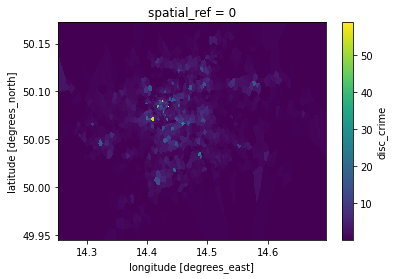

In [34]:
geo_grid.disc_crime.where(geo_grid.disc_crime!=geo_grid.disc_crime.rio.nodata).plot()
plt.show()

## Square points

In [36]:
df2 = pd.read_csv('/content/drive/MyDrive/reality/discounted_crime_2.csv', sep=',', delimiter=None, encoding="utf8")

In [37]:
df2 = df2.rename(columns={"disc_index": "disc_crime"})

In [38]:
df2.head()

,Unnamed: 0,index,id,x,y,date,types,crime_idx,cut_x,cut_y,disc_crime
0,0,85,6027950,14.423841,50.089270,2016-01-02,krádeže na osobách,0.038462,"(14.423, 14.425]","(50.0885, 50.0894]",0.020440
1,1,86,6027956,14.448420,50.082480,2016-01-02,krádeže součástek aut,0.031111,"(14.448, 14.449]","(50.0822, 50.0831]",0.016534
2,2,87,6027958,14.418877,50.077282,2016-01-02,vloupání do prodejny,0.038462,"(14.417, 14.419]","(50.0768, 50.0777]",0.020440
3,3,88,6027982,14.427781,50.078349,2016-01-02,krádeže na osobách,0.038462,"(14.426, 14.428]","(50.0777, 50.0786]",0.020440
4,4,89,6028004,14.421398,50.084477,2016-01-02,krádeže na osobách,0.038462,"(14.421, 14.423]","(50.084, 50.0849]",0.020440


Secteme body se stejnymi souradnicemi

In [41]:
df3 = df2[['id', 'x',	'y', 'cut_x', 'cut_y', 'disc_crime']].copy()

In [42]:
df3['xy'] = list(zip(df3.x, df3.y))

In [43]:
df3 = df3[df3.columns.difference(['x', 'y'])]

In [44]:
help1 = df3.groupby(['xy']).apply(lambda df3: df3['disc_crime'].sum())

In [45]:
help1

xy
(14.252392, 50.059311)    0.100560
(14.263671, 50.109646)    3.158116
(14.268226, 50.10447)     2.936840
(14.26839, 50.059282)     0.258757
(14.26859, 50.096719)     0.057759
                            ...   
(14.680413, 50.072187)    0.987694
(14.680481, 50.077492)    0.332667
(14.684184, 50.096478)    0.109620
(14.68783, 50.073627)     0.501258
(14.696, 50.087285)       0.028038
Length: 1724, dtype: float64

In [46]:
df4 = help1

In [47]:
type(df4)

pandas.core.series.Series

In [48]:
df4.index

Index([(14.252392, 50.059311), (14.263671, 50.109646),  (14.268226, 50.10447),
        (14.26839, 50.059282),  (14.26859, 50.096719), (14.270316, 50.108681),
       (14.270919, 50.066597), (14.271231, 50.113679), (14.272252, 50.046967),
       (14.272738, 50.044017),
       ...
       (14.670411, 50.084401), (14.670699, 50.077377), (14.674175, 50.069401),
       (14.674686, 50.073347), (14.676426, 50.099137), (14.680413, 50.072187),
       (14.680481, 50.077492), (14.684184, 50.096478),  (14.68783, 50.073627),
          (14.696, 50.087285)],
      dtype='object', name='xy', length=1724)

In [49]:
len(df4)

1724

In [50]:
len(df2['disc_crime'])

139408

Dataframe ma misto 139408 zaznamu pouze 1724.

In [51]:
df2['x'].nunique()

1721

In [52]:
df2['y'].nunique()

1714

In [53]:
df3.head()

,cut_x,cut_y,disc_crime,id,xy
0,"(14.423, 14.425]","(50.0885, 50.0894]",0.020440,6027950,"(14.423841, 50.08927)"
1,"(14.448, 14.449]","(50.0822, 50.0831]",0.016534,6027956,"(14.44842, 50.08248)"
2,"(14.417, 14.419]","(50.0768, 50.0777]",0.020440,6027958,"(14.418877, 50.077282)"
3,"(14.426, 14.428]","(50.0777, 50.0786]",0.020440,6027982,"(14.427781, 50.078349)"
4,"(14.421, 14.423]","(50.084, 50.0849]",0.020440,6028004,"(14.421398, 50.084477)"


In [54]:
d = {'xy': df4.index, 'disc_crime': df4}
df_final = pd.DataFrame(data = d)

Zbavime se nevhodneho indexovani xy

In [55]:
df_final.head()

,xy,disc_crime
xy,,
"(14.252392, 50.059311)","(14.252392, 50.059311)",0.100560
"(14.263671, 50.109646)","(14.263671, 50.109646)",3.158116
"(14.268226, 50.10447)","(14.268226, 50.10447)",2.936840
"(14.26839, 50.059282)","(14.26839, 50.059282)",0.258757
"(14.26859, 50.096719)","(14.26859, 50.096719)",0.057759


In [56]:
d = {'x_y': df_final['xy'], 'disc_crime': df_final['disc_crime']}
df_final2 = pd.DataFrame(data = d)

In [57]:
df_final2.reset_index()
df_final2.head()

,x_y,disc_crime
xy,,
"(14.252392, 50.059311)","(14.252392, 50.059311)",0.100560
"(14.263671, 50.109646)","(14.263671, 50.109646)",3.158116
"(14.268226, 50.10447)","(14.268226, 50.10447)",2.936840
"(14.26839, 50.059282)","(14.26839, 50.059282)",0.258757
"(14.26859, 50.096719)","(14.26859, 50.096719)",0.057759


In [58]:
df_final2['index'] = np.arange(0,len(df_final2['x_y']))

In [59]:
df_final2 = df_final2.set_index('index')

In [60]:
df_final2.head()

,x_y,disc_crime
index,,
0,"(14.252392, 50.059311)",0.100560
1,"(14.263671, 50.109646)",3.158116
2,"(14.268226, 50.10447)",2.936840
3,"(14.26839, 50.059282)",0.258757
4,"(14.26859, 50.096719)",0.057759


In [63]:
df_final2.loc[0,'x_y']

(14.252392, 50.059311)

In [64]:
df_final2.loc[0,'x_y'][0]

14.252392

In [66]:
d = {'cut_x': np.zeros(len(df_final2['x_y'])), 'cut_y': np.zeros(len(df_final2['x_y'])), 'disc_crime': np.zeros(len(df_final2['x_y']))}
df4 = pd.DataFrame(data=d)
for x in range(len(df_final2['disc_crime'])):
  df4.loc[x,'x'] = df_final2.loc[x,'x_y'][0]
  df4.loc[x,'y'] = df_final2.loc[x,'x_y'][1]
  df4.loc[x,'disc_crime'] = df_final2.loc[x, 'disc_crime']

Opet jsme rozdelili zaznamy na x a y

In [67]:
df4.head()

,cut_x,cut_y,disc_crime,x,y
0,0.0,0.0,0.100560,14.252392,50.059311
1,0.0,0.0,3.158116,14.263671,50.109646
2,0.0,0.0,2.936840,14.268226,50.104470
3,0.0,0.0,0.258757,14.268390,50.059282
4,0.0,0.0,0.057759,14.268590,50.096719


In [68]:
df4 = df4[df4.columns.difference(['cut_x', 'cut_y'])]

Provedeme cuty na 250 zaznamu

In [69]:
df4['cut_x'] = pd.cut(df4['x'], 250)

In [70]:
df4['cut_y'] = pd.cut(df4['y'], 250)

In [71]:
df4.head()

,disc_crime,x,y,cut_x,cut_y
0,0.100560,14.252392,50.059311,"(14.252, 14.254]","(50.0587, 50.0596]"
1,3.158116,14.263671,50.109646,"(14.263, 14.265]","(50.1093, 50.1102]"
2,2.936840,14.268226,50.104470,"(14.267, 14.268]","(50.1039, 50.1048]"
3,0.258757,14.268390,50.059282,"(14.268, 14.27]","(50.0587, 50.0596]"
4,0.057759,14.268590,50.096719,"(14.268, 14.27]","(50.0967, 50.0976]"


In [72]:
type(df4.loc[0,'cut_x'])

pandas._libs.interval.Interval

In [73]:
df4.loc[0,'cut_x'].left

14.252

In [74]:
d = {'x1': np.zeros(len(df4['x'])), 'x2': np.zeros(len(df4['x'])), 'y1': np.zeros(len(df4['x'])),
     'y2': np.zeros(len(df4['x'])), 'disc_crime': np.zeros(len(df4['x']))}
df_final = pd.DataFrame(data=d)
for x in range(len(df_final2['disc_crime'])):
  df_final.loc[x,'x1'] = df4.loc[x,'cut_x'].left
  df_final.loc[x,'x2'] = df4.loc[x,'cut_x'].right
  df_final.loc[x,'y1'] = df4.loc[x,'cut_y'].left
  df_final.loc[x,'y2'] = df4.loc[x,'cut_y'].right
  df_final.loc[x,'disc_crime'] = df4.loc[x, 'disc_crime']

In [75]:
df_final.head()

,x1,x2,y1,y2,disc_crime
0,14.252,14.254,50.0587,50.0596,0.100560
1,14.263,14.265,50.1093,50.1102,3.158116
2,14.267,14.268,50.1039,50.1048,2.936840
3,14.268,14.270,50.0587,50.0596,0.258757
4,14.268,14.270,50.0967,50.0976,0.057759


In [76]:
df_final[['x1','x2','y1','y2']].sort_values(by=['x1','x2','y1','y2'])

,x1,x2,y1,y2
0,14.252,14.254,50.0587,50.0596
1,14.263,14.265,50.1093,50.1102
2,14.267,14.268,50.1039,50.1048
3,14.268,14.270,50.0587,50.0596
4,14.268,14.270,50.0967,50.0976
...,...,...,...,...
1719,14.680,14.682,50.0713,50.0722
1720,14.680,14.682,50.0768,50.0777
1721,14.684,14.685,50.0958,50.0967
1722,14.687,14.689,50.0732,50.0741


## Mame kompletni souradnice hranicnich bodu (x1,y1),(x2,y1),(x1,y2),(x2,y2)

In [80]:
gdf = gdp.GeoDataFrame(
    df_final,
    geometry=gdp.points_from_xy(df_final["x1"], df_final["y2"]),
)

In [81]:
gdf

,x1,x2,y1,y2,disc_crime,geometry
0,14.252,14.254,50.0587,50.0596,0.100560,POINT (14.25200 50.05960)
1,14.263,14.265,50.1093,50.1102,3.158116,POINT (14.26300 50.11020)
2,14.267,14.268,50.1039,50.1048,2.936840,POINT (14.26700 50.10480)
3,14.268,14.270,50.0587,50.0596,0.258757,POINT (14.26800 50.05960)
4,14.268,14.270,50.0967,50.0976,0.057759,POINT (14.26800 50.09760)
...,...,...,...,...,...,...
1719,14.680,14.682,50.0713,50.0722,0.987694,POINT (14.68000 50.07220)
1720,14.680,14.682,50.0768,50.0777,0.332667,POINT (14.68000 50.07770)
1721,14.684,14.685,50.0958,50.0967,0.109620,POINT (14.68400 50.09670)
1722,14.687,14.689,50.0732,50.0741,0.501258,POINT (14.68700 50.07410)


Kontrola zda se nam neprekryvaji "policka"

In [82]:
xyxy = df_final[['x1','x2','y1','y2']]

In [83]:
df_final['xyxy'] = df_final["x1"].astype(str) + " " + df_final["y1"].astype(str) + " " + df_final["x2"].astype(str) + " " +  df_final["y2"].astype(str)

In [84]:
df_final['xyxy'].nunique()

1724

In [85]:
df_final = df_final.drop(['xyxy'], axis=1)

Zadna policka se neprekryvaji a disc_crime je secteny

In [294]:
from shapely import geometry

poly = geometry.Polygon([[p.x, p.y] for p in gdf['geometry']])

print(poly.wkt)

POLYGON ((14.252 50.0596, 14.263 50.1102, 14.267 50.1048, 14.268 50.0596, 14.268 50.0976, 14.27 50.1093, 14.27 50.0668, 14.27 50.1138, 14.272 50.0478, 14.272 50.0442, 14.272 50.0406, 14.274 50.0551, 14.274 50.0487, 14.275 50.1039, 14.275 50.0379, 14.275 50.0515, 14.275 50.0605, 14.275 50.0677, 14.277 50.0641, 14.277 50.046, 14.279 50.0569, 14.279 50.1084, 14.281 50.0722, 14.281 50.0497, 14.281 50.0994, 14.281 50.0623, 14.281 50.0361, 14.283 50.0587, 14.284 50.0442, 14.284 50.1147, 14.286 50.0921, 14.286 50.0533, 14.286 50.0334, 14.286 50.1066, 14.286 50.065, 14.286 50.0578, 14.286 50.0605, 14.288 50.1147, 14.288 50.0822, 14.288 50.0542, 14.288 50.0506, 14.288 50.0722, 14.29 50.0298, 14.29 50.0677, 14.291 50.0533, 14.291 50.0569, 14.291 50.1165, 14.291 50.046, 14.293 50.0352, 14.293 50.0596, 14.293 50.075, 14.293 50.0804, 14.293 50.0704, 14.295 50.0885, 14.295 50.0641, 14.295 50.0967, 14.295 50.0542, 14.295 50.1021, 14.297 50.0506, 14.299 50.0261, 14.299 50.0659, 14.299 50.0614, 14.299 

Toto nefunguje jak bychom chteli, asi je zde potreba rozdelit.

In [86]:
geo_grid = make_geocube(
    vector_data=gdf,
    measurements=['disc_crime'],
    resolution=(-0.001, 0.001),
    fill=0,
    rasterize_function=rasterize_points_griddata,
)

In [87]:
geo_grid

<xarray.Dataset>
Dimensions:      (y: 226, x: 442)
Coordinates:
  * y            (y) float64 50.17 50.17 50.17 50.17 ... 49.95 49.95 49.95 49.95
  * x            (x) float64 14.25 14.25 14.25 14.26 ... 14.69 14.69 14.69 14.69
    spatial_ref  int64 0
Data variables:
    disc_crime   (y, x) float64 0.08411 0.08411 0.08411 ... 0.09164 0.09164

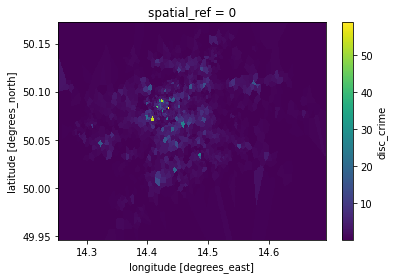

In [89]:
geo_grid.disc_crime.where(geo_grid.disc_crime!=geo_grid.disc_crime.rio.nodata).plot()

In [90]:
geo_grid = make_geocube(
    vector_data=gdf,
    measurements=['disc_crime'],
    resolution=(-0.002, 0.002),
    rasterize_function=partial(rasterize_image, all_touched=True),
)

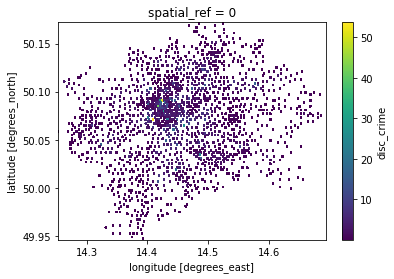

In [91]:
geo_grid.disc_crime.where(geo_grid.disc_crime!=geo_grid.disc_crime.rio.nodata).plot()

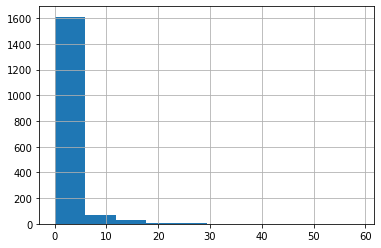

In [92]:
gdf['disc_crime'].hist()
plt.show()

Vidime jak jsou rozdeleny jednotlive disc_crime

In [301]:
gdf.describe()

,x1,x2,y1,y2,disc_index
count,1724.000000,1724.000000,1724.000000,1724.000000,1724.000000
mean,14.454284,14.456061,50.069530,50.070434,2.033400
std,0.086277,0.086272,0.043061,0.043060,3.796223
min,14.252000,14.254000,49.945500,49.946600,0.005314
25%,14.398000,14.400000,50.038800,50.039700,0.253607
50%,14.446000,14.448000,50.074100,50.075000,0.936211
75%,14.511000,14.513000,50.099400,50.100300,2.465392
max,14.694000,14.696000,50.170800,50.171700,58.778817


Rozdelime do 5 kategorii, 1 nejbezpecnejsi - 5 nejnebezpecnejsi.
Rozdeleni podle disc_crime hodnot cca:

level 1 - 37%

level 2 - 24%

level 3 - 18%

level 4 - 12%

level 5 - 9%

In [96]:
len(gdf[gdf['disc_crime']<5])/1724

0.9129930394431555

In [97]:
gdf['crime_level'] = 1

In [98]:
help = gdf['crime_level'].copy()

In [99]:
help[gdf['disc_crime'] > 0.5] = 2

In [100]:
help[gdf['disc_crime'] > 1.5] = 3
help[gdf['disc_crime'] > 2.7] = 4
help[gdf['disc_crime'] > 5] = 5

In [101]:
gdf['crime_level'] = help

In [102]:
gdf

,x1,x2,y1,y2,disc_crime,geometry,xyxy,crime_level
0,14.252,14.254,50.0587,50.0596,0.100560,POINT (14.25200 50.05960),14.252 50.0587 14.254 50.0596,1
1,14.263,14.265,50.1093,50.1102,3.158116,POINT (14.26300 50.11020),14.263 50.1093 14.265 50.1102,4
2,14.267,14.268,50.1039,50.1048,2.936840,POINT (14.26700 50.10480),14.267 50.1039 14.268 50.1048,4
3,14.268,14.270,50.0587,50.0596,0.258757,POINT (14.26800 50.05960),14.268 50.0587 14.27 50.0596,1
4,14.268,14.270,50.0967,50.0976,0.057759,POINT (14.26800 50.09760),14.268 50.0967 14.27 50.0976,1
...,...,...,...,...,...,...,...,...
1719,14.680,14.682,50.0713,50.0722,0.987694,POINT (14.68000 50.07220),14.68 50.0713 14.682 50.0722,2
1720,14.680,14.682,50.0768,50.0777,0.332667,POINT (14.68000 50.07770),14.68 50.0768 14.682 50.0777,1
1721,14.684,14.685,50.0958,50.0967,0.109620,POINT (14.68400 50.09670),14.684 50.0958 14.685 50.0967,1
1722,14.687,14.689,50.0732,50.0741,0.501258,POINT (14.68700 50.07410),14.687 50.0732 14.689 50.0741,2


In [103]:
geo_grid = make_geocube(
    vector_data=gdf,
    measurements=['disc_crime','crime_level'],
    resolution=(-0.002, 0.002),
    fill=0,
    rasterize_function=rasterize_points_griddata,
)

In [104]:
geo_grid

<xarray.Dataset>
Dimensions:      (y: 113, x: 221)
Coordinates:
  * y            (y) float64 50.17 50.17 50.17 50.16 ... 49.95 49.95 49.95 49.95
  * x            (x) float64 14.25 14.26 14.26 14.26 ... 14.69 14.69 14.69 14.69
    spatial_ref  int64 0
Data variables:
    disc_crime   (y, x) float64 0.08411 0.08411 0.08411 ... 0.09164 0.09164
    crime_level  (y, x) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1

In [105]:
geo_grid.info()

xarray.Dataset {
dimensions:
	y = 113 ;
	x = 221 ;

variables:
	float64 disc_crime(y, x) ;
		disc_crime:name = disc_crime ;
		disc_crime:long_name = disc_crime ;
		disc_crime:_FillValue = 0 ;
	int64 crime_level(y, x) ;
		crime_level:name = crime_level ;
		crime_level:long_name = crime_level ;
		crime_level:_FillValue = 0 ;
	float64 y(y) ;
		y:axis = Y ;
		y:long_name = latitude ;
		y:standard_name = latitude ;
		y:units = degrees_north ;
	float64 x(x) ;
		x:axis = X ;
		x:long_name = longitude ;
		x:standard_name = longitude ;
		x:units = degrees_east ;
	int64 spatial_ref() ;
		spatial_ref:crs_wkt = GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]] ;
		spatial_ref:semi_major_axis = 6378137.0 ;
		spatial_ref:semi_minor_axis = 6356752.3142

Nejsem si jisty zda funguje zcela jak ma...

In [106]:
geo_grid_arr = geo_grid.to_array(name='disc_crime')

In [107]:
geo_grid_arr

<xarray.DataArray 'disc_crime' (variable: 2, y: 113, x: 221)>
array([[[0.08410815, 0.08410815, 0.08410815, ..., 0.15535052,
         0.15535052, 0.15535052],
        [0.08410815, 0.08410815, 0.08410815, ..., 0.15535052,
         0.15535052, 0.15535052],
        [0.08410815, 0.08410815, 0.08410815, ..., 0.15535052,
         0.15535052, 0.15535052],
        ...,
        [0.08102754, 0.18217853, 0.18217853, ..., 0.09163667,
         0.09163667, 0.09163667],
        [0.18217853, 0.18217853, 0.18217853, ..., 0.09163667,
         0.09163667, 0.09163667],
        [0.18217853, 0.18217853, 0.18217853, ..., 0.09163667,
         0.09163667, 0.09163667]],

       [[1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        [1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        [1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        [1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        [1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ]]])
Coordinates:
  * y            (y) float64 50.17 50.17 50.17 50.16 ... 49.95 49.95 49.95 49.95
  * x            (x) float64 14.25 14.26 14.26 14.26 ... 14.69 14.69 14.69 14.69
    spatial_ref  int64 0
  * variable     (variable) <U11 'disc_crime' 'crime_level'